<a href="https://colab.research.google.com/github/luismartins26/segcomp/blob/main/Lista_de_Exerc%C3%ADcios_01_LE01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lista de Exercícios 01

CIC0201 - Segurança Computacional – 2025/1

Disciplina: Segurança Computacional

Professora: Lorena Borges

Estudante: Luís Martins (242037814)

# Introdução

O objetivo desse caderno é elaborar não só os códigos para realizar a cifra por deslocamento e transposição e a respectiva
decifração, mas também os códigos que quebram essas cifras, através de duas estratégias de ataques à cifra (CipherText-only), a dizer,
ataque de força bruta e distribuição de frequência. Além disso, almejo descrever a viabilidade das estratégias, comparar a complexidade dos algoritmos e
tempo de execução, onde cada técnica seria melhor aplicada etc.


Além da presente introdução, o caderno apresenta seções de Definições, Cifra por deslocamento, Cifra por transposição e Conclusão. Começo por delinear o arcabouço comuns às duas cifras, para, em seguida, implementar os algoritmos e análises individuais. As seções não devem ser tomadas individualmente, pois há considerações acerca da cifra por deslocamento que são aproveitadas na cifra por transposição. A conclusão encerra o caderno com uma síntese do que foi trabalhado.

Este trabalho contou com o auxílio de ferramentas de Inteligência Artificial (OPENAI, 2023; GOOGLE, 2024) para a geração de funções auxiliares e revisão do texto escrito. Todo o conteúdo gerado foi cuidadosamente revisado, ajustado e validado, garantindo a sua adequação, coerência e conformidade com os objetivos do trabalho.

# Definições

## Inicialização de bibliotecas e classe base

In [25]:
from abc import ABC, abstractmethod
import random
import math
from bs4 import BeautifulSoup
import requests
import numpy as np
import operator
import itertools

Em que pese a padronização do python para nomeação de parâmetros e métodos, sigo a definição utilizada na disciplina para a classe abstrata que guarda os principais métodos de criptografia. As cifras específicas são implementações particulares da classe abstrata.

In [26]:
class Cifra(ABC):
    @abstractmethod
    def Gen(self) -> any:
        pass

    def set_key(self, key):
        self.key = key

    @abstractmethod
    def Enc(self, M: str) -> str:
        pass

    @abstractmethod
    def Dec(self, C: str) -> str:
        pass

Mais precisamente, as definições são,

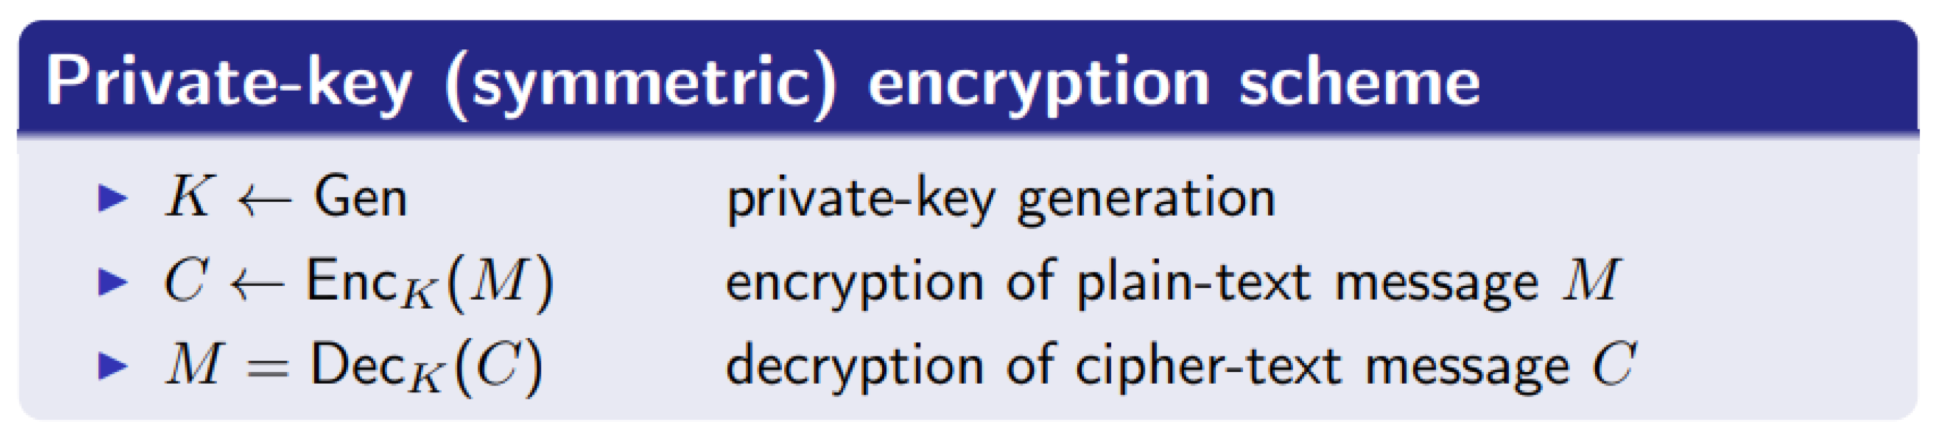

O método *set_key* foi adicionado para permitir a escolha de uma chave específica, ao invés de depender que o método *Gen* gere a chave específica desejada.

## Premissas sobre a mensagem

A mensagem é formada por um conjunto de caracteres alfabéticos minúsculos e sem acentuação mais espaço em branco, que separa palavras. Palavras provêm de um dicionário. Há um único espaço em branco entre as palavras e a mensagem não pode começar ou acabar com espaço em branco.

De maneira mais formal,

- $\mathcal{A}$ é um alfabeto, no nosso caso o das letras minúsculas sem acento $\{a, b, c, \dots, z\}$;
- $\mathcal{D} \subseteq \mathcal{A}^+$ um dicionário, isto é, o conjunto de todas as palavras válidas, onde $\mathcal{A}^+ = \mathcal{A} \cup \mathcal{A}^2 \cup \mathcal{A}^3 \dots$;
- $\sigma = \text{' '}$ o símbolo de espaço em branco;
- $\mathcal{A}' = \mathcal{A} \cup \{\sigma\}$ o conjunto de símbolos permitidos na mensagem.

Uma mensagem m é uma cadeia de caracteres $m \in \mathcal{M}$ tal que:

1. $m \in D$ ou
2. $m = p_1 \, \sigma \, p_2 \, \sigma \, \dots \, \sigma \, p_n$, para algum $n \in \mathbb{N}$, $n > 1$, com $p_i \in \mathcal{D}$;

### Dicionário

Proveniente de [FEOFILOFF (2024)](https://www.ime.usp.br/~pf/dicios/). Foram removidos todos os sinais de acentuação.

In [27]:
def extrair_dicionario():
    response = requests.get("https://www.ime.usp.br/~pf/dicios/br-sem-acentos.txt", stream=True)

    palavras = set()
    for l in response.iter_lines(decode_unicode=True):
        palavras.add(l.strip().lower())

    return palavras

dicionario_palavras = extrair_dicionario()

### Classe de teste

Com essas definições, podemos definir uma classe de teste para os algoritmos, para garantir que as premissas da mensagem sejam cumpridas e que as cifras funcionem corretamente.

In [28]:
class Verificador:
    def set_dicionario(self, dicionario):
        self.dicionario = dicionario

    def verificar_mensagem(self, M):
        for char in M:
            if not (char.isalpha() or char== ' '):
                return False

        for p in M.split(' '):
            if p not in self.dicionario:
                return False
        return True

verificador = Verificador()
verificador.set_dicionario(dicionario_palavras)

In [29]:
class TestadorCifra:
    def set_cifra(self, cifra):
        self.cifra = cifra

    def testar_cifra(self, M):
        self.cifra.set_key(self.cifra.Gen())
        C = self.cifra.Enc(M)
        M_ = self.cifra.Dec(C)
        return M == M_

## Corpus de teste

Para facilitar a execução de testes, gero um conjunto de textos que servem de mensagem ao longo do código. São salmos da bíblia, extraídos de [BÍBLIA ONLINE (s.d.)](https://www.bibliaonline.com.br/nvt/sl). Para se adequar à premissa de composição da mensagem, são removidas acentuações, marcações textuais e salmos com palavras inexistentes no dicionário.

In [30]:
# prompt: download all psalms from https://www.bibliaonline.com.br/nvt/sl

import requests
from bs4 import BeautifulSoup

def download_psalms():
    base_url = "https://www.bibliaonline.com.br/nvt/sl"
    all_psalms = []

    for i in range(1, 150+1):  # Psalms 1 to 150
        url = f"{base_url}/{i}"
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        soup = BeautifulSoup(response.content, "html.parser")
        psalm_text = [p.text.strip() for p in soup.find_all("span", class_="t")]
        all_psalms+=(psalm_text)

    return all_psalms


psalms = download_psalms()


In [31]:
# prompt: remove_accents_and_punctuation from the psalms. Hyphen should become blank space

import unicodedata
import re

def remove_accents_and_punctuation(text):
  text = ''.join(c for c in unicodedata.normalize('NFD', text)
                  if unicodedata.category(c) != 'Mn')
  text = re.sub(r'[^\w\s-]', '', text) # Remove punctuation except hyphens
  text = text.replace('-', ' ') # Replace hyphens with spaces
  return text.lower()

lista_textos = []
# Example usage with the downloaded psalms:
for i, psalm in enumerate(psalms):
    cleaned_psalm = remove_accents_and_punctuation(psalm)
    if(verificador.verificar_mensagem(cleaned_psalm)):
       lista_textos.append(cleaned_psalm)


In [32]:
class Corpus:
    def __init__(self, corpus):
        self.corpus = corpus

    def get_texto(self):
        return random.choice(self.corpus)

corpus = Corpus(lista_textos)

## Estatísticas

Para o ataque de frequência, as estatísticas são extraídas de [RIBEIRO (2024)](https://www.dcc.fc.up.pt/%7Ervr/naulas/tabelasPT/)

In [33]:
def extrair_estatisticas():
    response = requests.get("https://www.dcc.fc.up.pt/%7Ervr/naulas/tabelasPT/")

    soup = BeautifulSoup(response.content, "html.parser")

    tabelas = soup.find_all("table")
    tabelas_extraidas = []
    for tabela in tabelas:
      linhas = tabela.find_all("tr")
      tabela_extraida = []
      for l in linhas:
        cols = l.find_all(["td", "th"])
        dados = [col.text.strip() for col in cols]
        tabela_extraida.append(dados)
      tabelas_extraidas.append(tabela_extraida)

    tabela_frequecia_letras = tabelas_extraidas[0]
    tabela_frequencia_digrafos = tabelas_extraidas[1]
    tabela_frequencia_trigrafos = tabelas_extraidas[2]

    letras = [e for v in tabela_frequecia_letras[::2] for e in v]
    freqs = [e for v in tabela_frequecia_letras[1::2] for e in v]
    frequencia_letras = {letras[i]:float(freqs[i]) for i in range(len(letras))}

    trigrafos = [e for v in tabela_frequencia_trigrafos[::2] for e in v]
    freqs = [e for v in tabela_frequencia_trigrafos[1::2] for e in v]
    frequencia_trigrafos = {trigrafos[i]:float(freqs[i])/10_000 for i in range(len(trigrafos))}

    frequencia_digrafos = dict()
    for r in tabela_frequencia_digrafos[1:]:
        for i in range(1, len(r)-1):
            frequencia_digrafos[r[0]+tabela_frequencia_digrafos[0][i]] = float(r[i])/1_000

    # Extraído manualmente
    frequencia_vogais_consoantes = {'v':47.7/100,'c':52.3/100}

    return frequencia_letras, frequencia_trigrafos, frequencia_digrafos, frequencia_vogais_consoantes

frequencia_letras, frequencia_trigrafos, frequencia_digrafos, frequencia_vogais_consoantes = extrair_estatisticas()

# Cifra por Deslocamento

## Definição

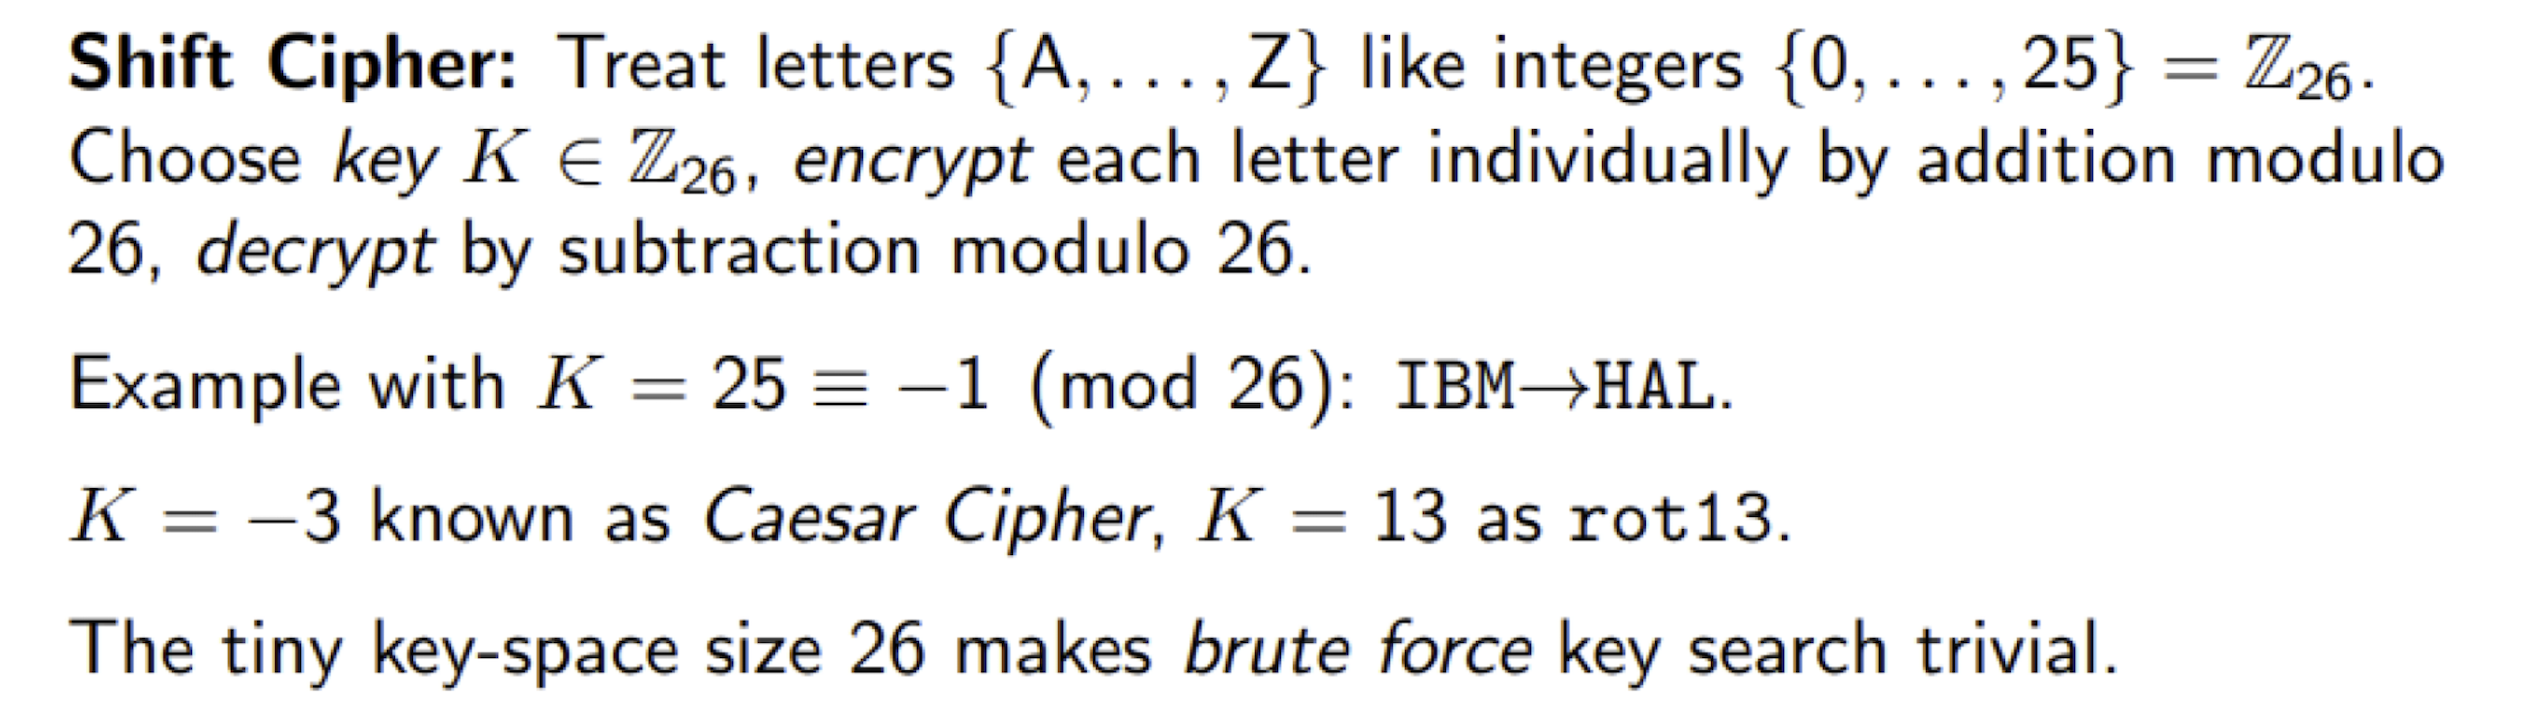

Sob essa definição, os espaços em branco são desconsiderados e apenas as letras da mensagem sofrem alteração.

## Implementação

In [177]:
class CifraDeslocamento(Cifra):
    def __init__(self):
        # Define o alfabeto usado pela cifra
        self.alfabeto = 'abcdefghijklmnopqrstuvxywz'

    def Gen(self):
        # Retorna um número inteiro aleatório no intervalo do tamanho do alfabeto
        return random.randint(0, len(self.alfabeto)-1)

    def Enc(self, M):
        # Inicializa a string criptografada
        C = ''
        # Percorre a mensagem
        for i in range(len(M)):
            # Flag para verificar se o caractere está no alfabeto
            faz_parte_alfabeto = False
            # Percorre o alfabeto
            for j in range(len(self.alfabeto)):
                if M[i] == self.alfabeto[j]:
                    # Aplica o deslocamento ao caractere
                    C += self.alfabeto[(j + self.key) % len(self.alfabeto)]
                    # Marca que o caractere foi transformado
                    faz_parte_alfabeto = True
                    # Interrompe a busca no alfabeto
                    break
            # Se o caractere (espaço) não pertence ao alfabeto, mantém o original
            if not faz_parte_alfabeto:
                C += M[i]
        return C

    def Dec(self, C):
        self.key = -self.key
        M = self.Enc(C)
        self.key = -self.key
        return M

## Teste

In [178]:
cifraCesar = CifraDeslocamento()
cifraCesar.set_key(3)
assert cifraCesar.Enc('luis') == 'oylv'
assert cifraCesar.Dec('oylv') == 'luis'

In [179]:
cifraDeslocamento = CifraDeslocamento()
testadorCifraDeslocamento = TestadorCifra()
testadorCifraDeslocamento.set_cifra(cifraDeslocamento)
for i in range(1000):
    assert testadorCifraDeslocamento.testar_cifra(corpus.get_texto())

## Análise de complexidade da cifra

A complexidade algorítimica da cifra de deslocamento na operação de encriptação é dominada pelos dois laços do processo de formação da mensagem cifrada. Primeiramente, a mensagem é percorrida completamente, então inicia-se com
$O (|m|)$ correspondente ao tamanho da mensagem. Para a realização do deslocamento de letra, no pior caso, deve-se percorrer todo o alfabeto até se chegar à letra correspondente para realizar a operação. Para cada letra da mensagem, essa operação deve ser realizada, então teremos que a complexidade da cifra é da ordem de $O (|m|\cdot|\mathcal{A}|)$, polinomial. Como a operação de decriptação é análoga à de encriptação, a complexidade é a mesma.


## Ataque de força bruta

O ataque é razoavelmente simples, pois basta percorrer todas as chaves possíveis, descriptografar com a chave tentativa e verificar a validade da mensagem. Nesse caso, a complexidade da quebra da cifra no pior caso é proporcional à complexidade da encriptação da cifra no pior caso vezes o tamanho do alfabeto $|\mathcal{A}|$, pois corresponde ao total de chaves possíveis. Porém, não basta apenas gerar todas as possibilidades de chave, ainda é necessário verificar qual das chaves quebra a cifra e gera uma mensagem válida. Assim, o resultado final no pior dos casos precisa percorrer o dicionário de tamanho $|\mathcal{D}|$ e verificar se todas as palavras são válidas. Então a complexidade no pior caso é $O(|m|\cdot|\mathcal{A}|\cdot |\mathcal{A}| \cdot |\mathcal{D}|)$, ainda polinomial.

In [180]:
def ataque_forca_bruta(C):
  cifraDeslocamento = CifraDeslocamento()
  # Percorre o espaço de chaves, que corresponde ao tamanho do alfabeto
  for i in range(len(cifraDeslocamento.alfabeto)):
      cifraDeslocamento.set_key(i)
      M = cifraDeslocamento.Dec(C)
      if verificador.verificar_mensagem(M):
          return i, M
  raise Exception("Cifra não corresponde a mensagem válida.")


In [181]:
cifraDeslocamento = CifraDeslocamento()
k = cifraDeslocamento.Gen()
cifraDeslocamento.set_key(k)
M = corpus.get_texto()
C = cifraDeslocamento.Enc(M)
print(M)
print(k)
print(C)

para que a geracao seguinte os filhos ainda por nascer
20
julu kow u awluxui mwaochnw im zcfbim uchyu jil humxwl


In [182]:
ataque_forca_bruta(C)

(20, 'para que a geracao seguinte os filhos ainda por nascer')

## Ataque por distribuição de frequência

O ataque consiste em encontrar a chave por meio da distribuição de frequências de letras da mensagem cifrada. A partir das estatísticas geradas do caso concreto, procura-se a combinação que apresente a máxima verossimilhança com a distribuição geral das estatísticas das mensagens em geral. No nosso caso, as estatísticas são contagens de letras.

A distribuição de letras é modelável como uma distribuição categórica. Não há qualquer razão para que se atribua uma chance maior para determinada letra antes de se observarem os dados, então a distribuição a priori é simplesmente não informativa ou $\frac{1}{|\mathcal{A}|}$ para cada letra.
A mensagem pode ser entendida como uma variável aleatória $M = X_1X_2\dots X_n$, em que $X_i$ é variável aleatória de uma letra que segue distribuição categórica das letras em mensagens em geral.
Por sua vez, a distribuição posterior é proporcional à contagem de letras na mensagem mais 1 do parâmetro a priori normalizado pela soma do tamanho da mensagem mais o tamanho do alfabeto.

$$P(X=a \in \mathcal{A} | M) = \frac{1+\#\{X=X_i, X_i\in M\}}{|M|+|\mathcal{A}|}$$

A distribuição de letras da mensagem cifrada é uma das $|\mathcal{A}|$ possibilidades, haja vista que há esse número de deslocamentos possíveis entre as letras do alfabeto. Por sua vez, a verossimilhança máxima ocorre quando consideramos a menor divergência entre a distribuição estimada e a distribuição geral. Uso a métrica da divergência de Kullback–Leibler (COVER, THOMAS, 1991) entre as distribuições em questão e a distribuição geral para encontrar a distribuição mais adequada, isto é, a que gera menor divergência.

$$D_{\mathrm{KL}}(P \parallel Q) = \sum_{x \in \mathcal{A}} P(x) \log \left( \frac{P(x)}{Q(x)} \right)$$

In [183]:
# prompt: count number of letters in string for each letter, returning dictionaries

from collections import Counter

def count_letters(text):
  """Counts the occurrences of each letter in a string.

  Args:
    text: The input string.

  Returns:
    A dictionary where keys are letters and values are their counts.
  """
  letter_counts = Counter(text.lower())
  dicio = dict(letter_counts)
  if ' ' in dicio:
      dicio.pop(' ')
  return dicio


In [184]:
def calcular_KL(freq_estimada):
    KL = 0
    for c in 'abcdefghijklmnopqrstuvxywz':
        if frequencia_letras[c] == 0:
            # Evita divisão por zero ou log(0)
            continue
        KL += frequencia_letras[c]*np.log(frequencia_letras[c]/freq_estimada[c])
    return KL

def ataque_dist(C):
    # Conta a ocorrência de cada letra na cifra
    contagem = count_letters(C)
    # Cálculo da normalização de parâmetros
    total_letras = np.sum(list(contagem.values()))+26
    freq_estimada = dict()
    alfabeto = 'abcdefghijklmnopqrstuvxywz'
    for c in alfabeto:
        if c in contagem:
            freq_estimada[c] = (contagem[c]+1)/total_letras
        else:
            # Se a letra não aparecer, assume 1
            freq_estimada[c] = 1/total_letras

    KL ={}
    # Realiza deslocamentos no alfabeto para testar diferentes possibilidades
    for i in range(len(alfabeto)):
        freq_estimada_deslocada = {}
        for j in range(len(alfabeto)):
            freq_estimada_deslocada[alfabeto[(j-i)%len(alfabeto)]] = freq_estimada[alfabeto[j]]
        KL[i] = calcular_KL(freq_estimada_deslocada)
    # Retorna a chave de deslocamento com menor divergência KL
    return min(KL.items(), key=operator.itemgetter(1))[0]

Encontramos um ótimo resultado na probabilidade de acertar a distribuição no corpus de teste, mas isso ocorre porque as mensagens possuem determinado comprimento. Podemos nos perguntar o que acontece se se variar o tamanho da mensagem.

In [185]:
acerto = 0
for i in range(1000):
    k = cifraDeslocamento.Gen()
    cifraDeslocamento.set_key(k)
    M = corpus.get_texto()
    C = cifraDeslocamento.Enc(M)
    k_ = ataque_dist(C)
    if k == k_:
        acerto += 1
print(acerto/1000)

0.961


In [186]:
# prompt: choose letters from frequencia_letras according to its probability

import random

def choose_letter_by_probability():
  """Chooses a letter from frequencia_letras according to its probability.

  Args:
    frequencia_letras: A dictionary where keys are letters and values are their probabilities.

  Returns:
    A randomly chosen letter based on the given probabilities.
  """
  letters = list(frequencia_letras.keys())
  probabilities = list(frequencia_letras.values())
  return random.choices(letters, weights=probabilities, k=1)[0]


In [187]:
prob_estimada = {}
for i in range(25):
    prob = 0
    for j in range(1000):
        M = ''
        for k in range(i):
            M += choose_letter_by_probability()
        k = cifraDeslocamento.Gen()
        cifraDeslocamento.set_key(k)
        C = cifraDeslocamento.Enc(M)
        k_ = ataque_dist(C)
        if k == k_:
            prob += 1
    prob_estimada[i] = prob/1000

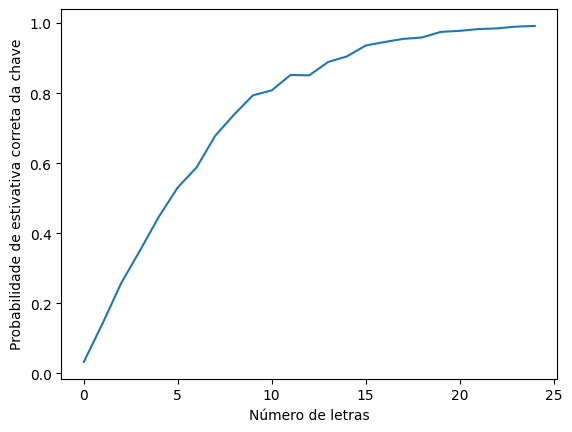

In [188]:
# prompt: plot prob_estimada

import matplotlib.pyplot as plt

# Assuming prob_estimada is defined as in your provided code
plt.plot(list(prob_estimada.keys()), list(prob_estimada.values()))
plt.xlabel("Número de letras")
plt.ylabel("Probabilidade de estivativa correta da chave")
plt.show()


Conforme esperado, à medida que a mensagem cresce, aumenta-se a probabilidade de se quebrar a cifra, com uma probabilidade superior a 95% estimada para mensagens acima de 16 caracteres.

In [189]:
prob_estimada

{0: 0.033,
 1: 0.143,
 2: 0.259,
 3: 0.352,
 4: 0.448,
 5: 0.531,
 6: 0.588,
 7: 0.679,
 8: 0.739,
 9: 0.794,
 10: 0.808,
 11: 0.852,
 12: 0.851,
 13: 0.889,
 14: 0.905,
 15: 0.936,
 16: 0.946,
 17: 0.955,
 18: 0.959,
 19: 0.975,
 20: 0.978,
 21: 0.983,
 22: 0.985,
 23: 0.99,
 24: 0.992}

# Cifra por Transposição

## Definição

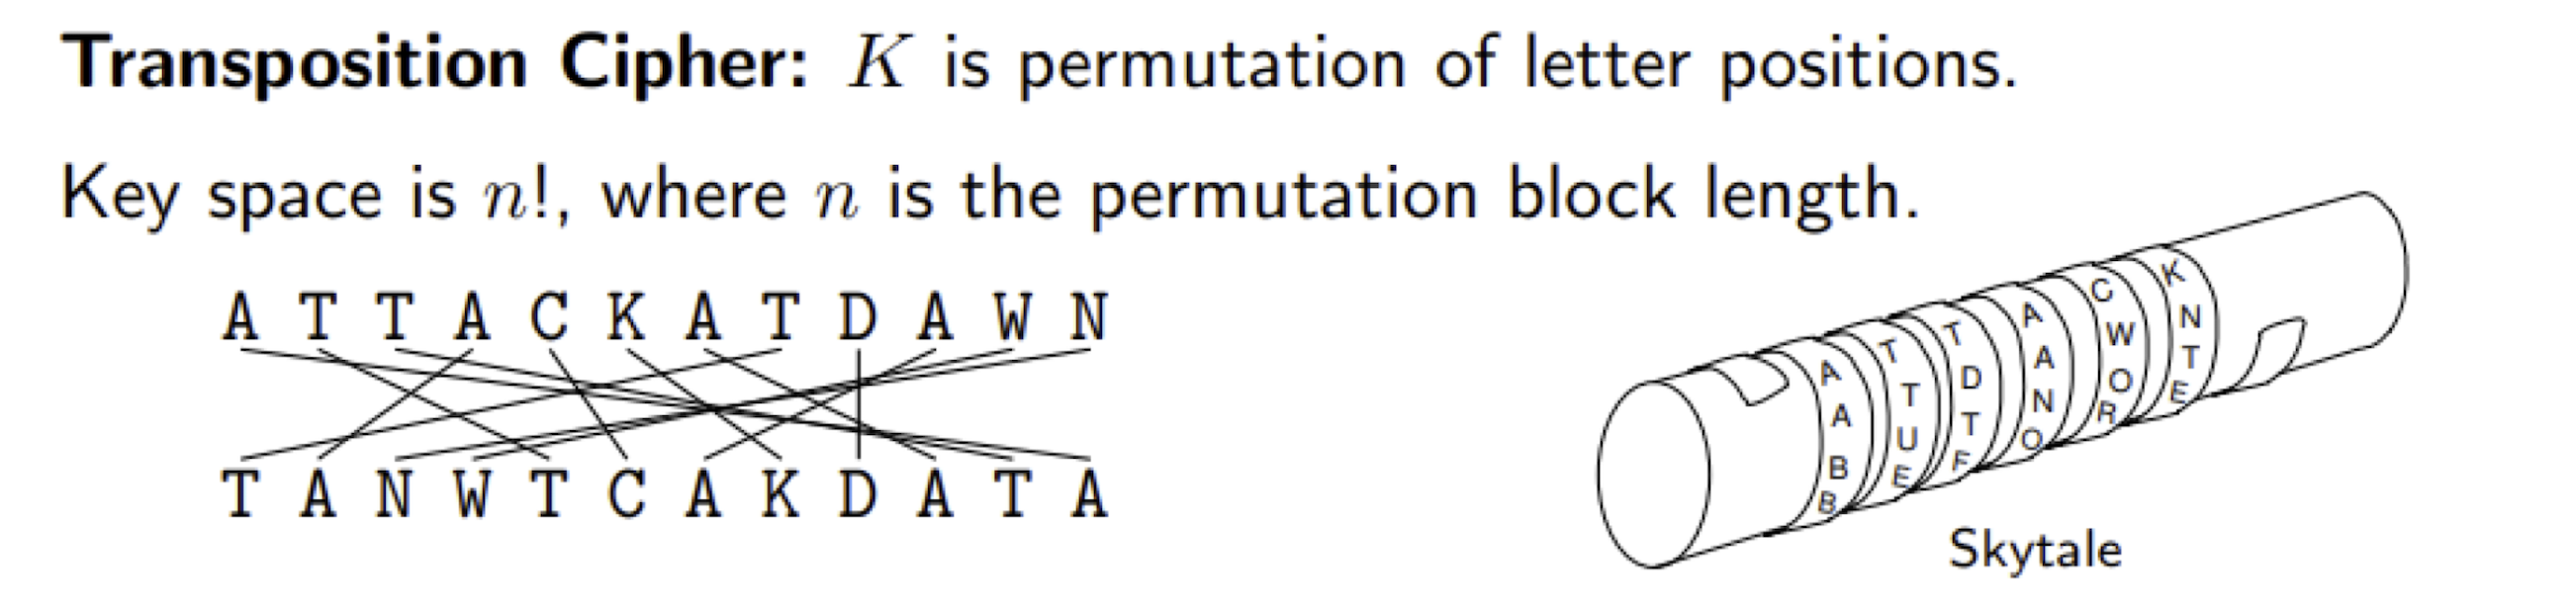

Em que pese a definição ser completa, não especifica como representar a chave. Recorro à álgebra abstrata (BOGART, 1990) para alcançar tal representação.

A notação de uma linha representa uma permutação listando diretamente a imagem de cada elemento na ordem.

Seja uma permutação $ \Pi $ do conjunto $ P = \{1, 2, \dots, n\} $, com $\pi:P→P$ bijetora, então:

$$
\Pi = \begin{pmatrix}
1 & 2 & \cdots & n \\
\pi(1) & \pi(2) & \cdots & \pi(n)
\end{pmatrix}
$$

Na notação de uma linha, escrevemos apenas a segunda linha, que representa a chave da permutação:

$$
\Pi' = [\pi(1)\ \pi(2)\ \cdots\ \pi(n)]
$$

Caso a permutação tenha comprimento diferente do da mensagem, no processo de encriptação, espaços em branco são adicionados (*padding*) até que o comprimento da mensagem seja divisível pelo comprimento da chave. Se a chave tiver mesmo comprimento da mensagem estendida, a permutação é realizada. Se a chave tiver tamanho inferior, a mensagem é dividida em blocos do tamanho da chave, os blocos são permutados conforme a chave e unidos novamente, mantendo a ordem original em que foram divididos.

O processo de decriptação é análogo ao da encriptação. Sendo a permutação uma bijeção, garante-se a existência de uma inversa, que se aplica à mensagem criptografada e possui uma chave correspondente com o mesmo tamanho da chave de encriptação. Uma vez que já ocorreu *padding* na encriptação, o tamanho da mensagem cifrada é divisível pelo tamanho da chave de decriptação, que pode ser aplicada à mensagem toda ou ao seus blocos correspondentes.
Ao final do processo de decriptação, os espaços em branco adicionados na encriptação são retirados, caso existam, de modo que a mensagem decriptada é igual à encriptada.

A chave de decriptação pode ser obtida a partir da ordenação das colunas de $\Pi$ usando como base a segunda linha da matriz, pois corresponde à inversa da permutação original $\pi$.

$$
\Pi=
\begin{pmatrix}
1 & 2 & \cdots & n \\
\pi(1) & \pi(2) & \cdots & \pi(n)
\end{pmatrix}
\underset{\text{ordenação}} \longrightarrow
\begin{pmatrix}
\pi^{-1}(1) & \pi^{-1}(2) & \cdots & \pi^{-1}(n) \\
1 & 2 & \cdots & n
\end{pmatrix}
=\Pi^{-1}
$$

## Implementação

In [47]:
class CifraTransposicao(Cifra):
    def Gen(self, L:int):
        chave = list(range(L))
        random.shuffle(chave)
        return chave

    def Enc(self, M):
        # Cria a lista C preenchida com espaços para armazenar o texto cifrado
        C = [' ']*math.ceil(len(M)/len(self.key))*len(self.key)
        # Preenche a mensagem original com espaços extras
        M = M+' '*(math.ceil(len(M)/len(self.key))*len(self.key)-len(M))
        # Para cada bloco de tamanho igual ao da chave
        for j in range(math.ceil(len(M)/len(self.key))):
            # Aplica a permutação no bloco
            for i, k in enumerate(self.key):
                C[j*len(self.key)+i] = M[j*len(self.key)+k]
        # Junta a lista de caracteres em uma string e retorna o texto cifrado
        return "".join(C)

    def set_key(self, key):
        self.key = key
        self.chave_inversa = [item[1] for item in sorted(zip(self.key, range(len(self.key))))]

    def Dec(self, C):
        chave_antiga = self.key
        self.key = self.chave_inversa
        M = self.Enc(C)
        self.key = chave_antiga
        # Retira espaços extras do padding
        return M.strip()


## Teste

In [48]:
cifraTransposicao = CifraTransposicao()
cifraTransposicao.set_key([3,2,1,0])
assert cifraTransposicao.Enc('luis') == 'siul'
assert cifraTransposicao.Dec('siul') == 'luis'

In [49]:
class TestadorCifraTransposicao(TestadorCifra):
    def testar_cifra(self, M):
        chave = self.cifra.Gen(random.randint(1, len(M)))
        self.cifra.set_key(chave)
        C = self.cifra.Enc(M)
        M_ = self.cifra.Dec(C)
        return M == M_

In [50]:
testadorCifraTransposicao = TestadorCifraTransposicao()
testadorCifraTransposicao.set_cifra(cifraTransposicao)
for i in range(1000):
    assert testadorCifraTransposicao.testar_cifra(corpus.get_texto())

## Análise de complexidade da cifra

O algoritmo de encriptação é dominado pelos dois laços aninhados de operação de percorrer os blocos da mensagem e a chave em si, o que resulta em tempo polinomial $O(\lceil \frac{|m|}{|k|} \rceil \cdot |k|)$. Para o processo de decriptação, é necessário que seja gerada chave inversa, o que soma à complexidade uma ordenação $O(\lceil \frac{|m|}{|k|} \rceil \cdot |k| + |k|\cdot log(|k|))$.

## Ataque de força bruta

Em que pese o tempo polinomial do processo de encriptação/decriptação, mesmo com o percurso do dicionário para a verificação do texto quebrado, o número de permutações é fatorial, de modo que é o termo que acaba dominando a complexidade do algoritmo de quebra de cifra por transposição. Além disso, o ataque de força bruta não garante que a quebra de fato ocorra para a mensagem originalmente enviada, caso a mensagem comporte mais de uma combinação de palavras possível (um anagrama).

In [51]:
def ataque_forca_bruta(C):
    cifraTransposicao = CifraTransposicao()
    for i in range(1, len(C)):
        chaves = list(itertools.permutations(list(range(i))))
        # Percorre todo o espaço de permutações
        for k in chaves:
            # Pula chaves cujo comprimento não divide o tamanho da mensagem
            if len(C) % i != 0:
                continue
            cifraTransposicao.set_key(k)
            M = cifraTransposicao.Dec(C)
            if verificador.verificar_mensagem(M):
                return k, M

In [52]:
cifraTransposicao = CifraTransposicao()
k = cifraTransposicao.Gen(5)
cifraTransposicao.set_key(k)
M = corpus.get_texto()
C = cifraTransposicao.Enc(M)
print(M)
print(k)
print(C)

em vez disso que os pobres e os necessitados louvem teu nome
[4, 3, 2, 0, 1]
ev emsidz uq so soe erbpoo es cens tises soadevulouetm emo n


In [53]:
ataque_forca_bruta(C)

((4, 3, 2, 0, 1),
 'em vez disso que os pobres e os necessitados louvem teu nome')

## Ataque por distribuição de frequência

Não se pode repetir a estratégia do ataque de distribuição de frequência da cifra por deslocamento, pois a contagem de letras é uma operação invariante sob permutação. Qualquer permutação da mensagem produz as mesmas estatísticas de contagem de letras, portanto sigo o ataque pela distribuição de dígrafos, pares de letras. Infelizmente ainda não é possível repetir os mesmos métodos anteriores, pois a fonte de dados apresenta apenas a estimativa dos dígrafos, mas não a probabilidade condicional de dígrafos sequenciais, que seria necessária para estimar os parâmetros, pois em uma mensagem os dígrafos não são independentes entre si. Desconheço tais estatísticas para a língua portuguesa.

A solução encontrada foi o estabelecimento de uma heurística que busca representar o caso com maior probabilidade de ocorrer. A heurística consiste em contar os dígrafos encontrados na mensagem, ponderados por sua frequência geral. As permutações que geram esses scores mais elevados tendem a ser mais prováveis que outras permutações. O mesmo problema de anagramas ocorre nessa estratégia. Como o ataque é do tipo *cypher text only*, não se pode limitar de antemão o tamanho da chave, de modo que se deve percorrer todo o espaço de permutações possíveis do tamanho da mensagem cifrada.

In [54]:
# prompt: extract digraphs of a string

def extract_digraphs(text):
    """
    Extracts digraphs from a given text.

    Args:
        text: The input text string.

    Returns:
        A list of digraphs found in the text.
    """
    digraphs = []
    for i in range(len(text) - 1):
        digraph = text[i:i+2]
        if digraph.isalpha():  # Consider only digraphs of alphabetic characters
            digraphs.append(digraph)
    return digraphs



In [55]:
def heuristica(M):
    score = 0
    for p in M.split(' '):
        for d in extract_digraphs(p):
            if d in frequencia_digrafos:
                score += frequencia_digrafos[d]
    return score

In [136]:
def ataque_dist(C):
    cifraTransposicao = CifraTransposicao()
    score = {}
    for i in range(1, 8):
        # Pula chaves cujo comprimento não divide o tamanho da mensagem
        if len(C) % i != 0:
            continue
        chaves = list(itertools.permutations(list(range(i))))
        for k in chaves:
            cifraTransposicao.set_key(k)
            M = cifraTransposicao.Dec(C)
            score[k] = heuristica(M)
    # Retorna chave com maior score
    return max(score.items(), key=operator.itemgetter(1))[0]

Para fins de teste, o espaço de permutação da cifra de transposição é limitado, pois não há espaço ou tempo suficiente para o percurso completo do espaço de permutações.

In [171]:
acerto = 0
for i in range(100):
    k = cifraTransposicao.Gen(5)
    cifraTransposicao.set_key(k)
    M = corpus.get_texto()
    C = cifraTransposicao.Enc(M)
    k_ = ataque_dist(C)
    cifraTransposicao.set_key(k_)
    M_ = cifraTransposicao.Dec(C)
    if M == M_:
        acerto += 1
print(acerto/100)

0.4


A probabilidade de acerto é baixa, sem garantia que aumentar o espaço procurado implique em aumento na probabilidade de acerto, por conta de nossa dependência em heurística e não em análise estatística fundamentada. Mesmo que isso ocorresse, um anagrama com maior ocorrência de dígrafos mais comuns poderia ser privilegiado sobre a verdadeira mensagem.

In [172]:
prob_estimada = {}
for i in range(2,7):
    prob = 0
    for j in range(100):
        k = cifraTransposicao.Gen(i)
        cifraTransposicao.set_key(k)
        M = corpus.get_texto()
        C = cifraTransposicao.Enc(M)
        k_ = ataque_dist(C)
        cifraTransposicao.set_key(k_)
        M_ = cifraTransposicao.Dec(C)
        if M == M_:
            prob += 1
    prob_estimada[i] = prob/100

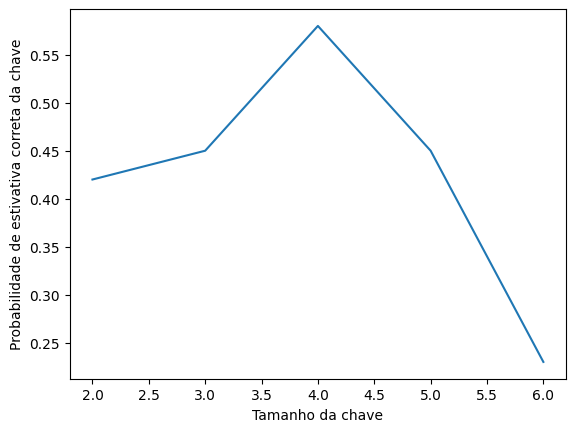

In [173]:
# prompt: plot prob_estimada

import matplotlib.pyplot as plt

# Assuming prob_estimada is defined as in your provided code
plt.plot(list(prob_estimada.keys()), list(prob_estimada.values()))
plt.xlabel("Tamanho da chave")
plt.ylabel("Probabilidade de estivativa correta da chave")
plt.show()


Não vemos tendência clara no tamanho da chave sobre a probabilidade de estivativa correta da chave. Com um tamanho inferior de chave, esperava que se alcança-se uma taxa de acertos maior, mas não ocorreu. A conclusão é limitada pelo espaço percorrido.

## Métodos alternativos

Os métodos de quebra anteriores envolvem o percurso do espaço de todas as permutações possíveis, o que é inviável para uma chave suficientemente grande. Um método alternativo mais interessante pode ser o percurso mais "inteligente" nas permutações possíveis. Na medida em que permutações "próximas" da chave original revelam mensagens quebradas também "próximas" da mensagem original, é possível explorar um subconjunto de permutações que cheguem à quebra do texto cifrado. Um método alternativo é por meio de algoritmos genéticos (BANZHAF *et al.*, 1998), que funcionam à semelhança dos mecanismos de adaptação da evolução natural.

O algoritmo genético inicia com a geração de uma população inicial composta por chaves  aleatórias, que representam os indivíduos da população. Em seguida, cada chave é avaliada por meio de uma função de aptidão (*fitness*), que consiste em aplicar a chave à mensagem cifrada e medir quantas palavras do resultado pertencem a um dicionário pré-definido. Essa avaliação permite identificar os indivíduos mais adaptados ao problema.

Com base nessa avaliação, o algoritmo realiza a seleção dos melhores indivíduos, ou seja, das chaves que mais se aproximam de uma solução correta. Esses indivíduos selecionados são então usados no processo de cruzamento (*crossover*), em que partes de duas chaves são combinadas para gerar novas chaves (filhos), com o intuito de herdar características vantajosas de ambos os pais.

Para manter a diversidade genética da população e evitar que o algoritmo fique preso em soluções locais, uma operação de mutação é aplicada às chaves, alterando aleatoriamente pequenos trechos da permutação. Após o cruzamento e a mutação, uma nova geração é formada, substituindo total ou parcialmente a anterior.

Esse processo é repetido por várias gerações. O resultado final é uma chave de permutação que, ao ser aplicada à mensagem cifrada, gera um texto com alta ocorrência de palavras válidas.

In [70]:
# prompt: perform single random swap of elements on a list

import random

def swap_random_elements(data):
  # Check if the list has at least two elements
  if len(data) < 2:
    return data

  # Choose two distinct random indices
  idx1, idx2 = random.sample(range(len(data)), 2)

  # Swap the elements at the chosen indices
  data[idx1], data[idx2] = data[idx2], data[idx1]

  return data


In [71]:
# prompt: create genetic algorithm solution

import random

class Individual:
    def __init__(self, chromosome):
        self.chromosome = chromosome
        self.fitness = 0
        self.cifra = CifraTransposicao()
        self.cifra.set_key(self.chromosome)

    def calculate_fitness(self, target):
        score = 0
        for p in self.cifra.Dec(target).split(' '):
            if p in dicionario_palavras:
                score += 1
        self.fitness = score

class GeneticAlgorithm:
    def __init__(self, target, population_size, mutation_rate):
        self.target = target
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.population = []
        self.generation = 0
        self.cifra = CifraTransposicao()

    def initialize_population(self):
        for _ in range(self.population_size):
            chromosome = self.cifra.Gen(len(self.target))
            self.population.append(Individual(chromosome))

    def calculate_fitness(self):
        for individual in self.population:
            individual.calculate_fitness(self.target)

    def select_parents(self):
        # Tournament selection
        parents = []
        for _ in range(2):
            tournament = random.sample(self.population, 3)
            parents.append(max(tournament, key=lambda x: x.fitness))
        return parents

    def crossover(self, parent1, parent2):
        crossover_point = random.randint(1, len(self.target) - 1)
        child1 = parent1.chromosome[:crossover_point] + parent2.chromosome[crossover_point:]
        child2 = parent2.chromosome[:crossover_point] + parent1.chromosome[crossover_point:]
        return Individual([int(c) for c in child1]), Individual([int(c) for c in child2])

    def mutate(self, individual):
        mutated_chromosome = list(individual.chromosome)
        for i in range(len(mutated_chromosome)):
            if random.random() < self.mutation_rate:
                mutated_chromosome = swap_random_elements(mutated_chromosome)
        individual.chromosome = mutated_chromosome

    def evolve(self):
        self.generation += 1
        new_population = []
        while len(new_population) < self.population_size:
            parent1, parent2 = self.select_parents()
            child1, child2 = self.crossover(parent1, parent2)
            self.mutate(child1)
            self.mutate(child2)
            new_population.extend([child1, child2])

        self.population = new_population[:self.population_size] #keep population size constant
        self.calculate_fitness()

    def find_solution(self, max_generations):
        self.initialize_population()
        self.calculate_fitness()

        for _ in range(max_generations):
            best_individual = max(self.population, key=lambda x: x.fitness)
            if best_individual.fitness == len(self.target):
                return best_individual.chromosome

            self.evolve()

        best_individual = max(self.population, key=lambda x: x.fitness)
        return best_individual.chromosome  # Return the best found solution




In [174]:
score_genetico = 0
score_prob = 0
for i in range(100):
    # Example Usage (replace with your actual target string)
    M = 'ola mundo'
    cifraTransposicao = CifraTransposicao()
    cifraTransposicao.set_key(cifraTransposicao.Gen(len(M)))
    C = cifraTransposicao.Enc(M)
    ga = GeneticAlgorithm(C, 100, 0.01)
    solution = ga.find_solution(1000)  # Run for 1000 generations
    cifraTransposicao.set_key(solution)

    for p in cifraTransposicao.Dec(C).split(' '):
        if p in dicionario_palavras:
            score_genetico += 1

    chave_dist = ataque_dist(C)
    cifraTransposicao.set_key(chave_dist)
    for p in cifraTransposicao.Dec(C).split(' '):
        if p in dicionario_palavras:
            score_prob += 1

In [175]:
score_genetico/100

1.58

In [176]:
score_prob/100

0.13

O texto de teste 'ola mundo' é composto por 2 palavras válidas. A quebra da cifra por algoritmo genético acertou em média uma palavra (não necessariamente qualquer palavra da mensagem original), ao passo que a quebra por frequência não chega a encontrar qualquer palavra, em média.

In [170]:
M = corpus.get_texto()
cifraTransposicao = CifraTransposicao()
cifraTransposicao.set_key(cifraTransposicao.Gen(len(M)))
C = cifraTransposicao.Enc(M)
ga = GeneticAlgorithm(C, 100, 0.01)
solution = ga.find_solution(1000)  # Run for 1000 generations
cifraTransposicao.set_key(solution)
M_ = cifraTransposicao.Dec(C)
print(M)
print(M_)

nacoes estrangeiras se encolhem diante de mim
e sa a e e do tnsmmeagieadresmlnsioeennrihctc


Mesmo com o resultado anterior, a abordagem de algoritmos genéticos pode enfrentar problemas, por conta do grande espaço de permutações possíveis.

# Conclusão

Discorri sobre as cifras por deslocamento e transposição, consolidando uma rápida contextualização teórica sobre as cifras e técnicas utilizadas, inspeção/explicação dos códigos, saídas dos testes realizados, comparativos e análises no contexto de segurança computacional. Ambas as cifras encriptam/decriptam em tempo polinomial ou polimial mais log-linear, porém a cifra de transposição apresenta maior segurança em termos de quebra por *cypher text only*, por conta do espaço de permutações que cresce fatorialmente com o tamanho da chave utilizada. A chave mais forte teria o tamanho da mensagem, o que se aproxima do resultado do segredo perfeito de Shannon, pois quanto maior a chave, maior a quantidade de permutações. Uma análise mais detida seria necessária para averiguar se a criação de chaves maiores que a mensagem e aplicação de *padding* geraria ganhos de segurança.

Sobre a trindade dos objetivos de segurança computacional confidencialidade-integridade-disponibilidade, os algoritmos abordados não chegam a tocar no tema de disponibilidade, que seria trabalhado pelo sistema em que hospeda os artefatos de segurança computacional, como mensagem, chave, mensagem cifrada e etc. Ambos algoritmos garantem a integridade da mensagem, mesmo que a cifra de transposição envolva *padding*, pois ainda assim a mensagem original pode ser recuperada. O que diferencia os dois algoritmos é o cumprimento de confidencialidade. Por conta do pequeno espaço de possibilidades, a cifra de deslocamento pode ser facilmente quebrada por força bruta, o que não ocorre com a cifra por transposição.

# Referências

BANZHAF, Wolfgang; NORDIN, Peter; KELLER, Robert; FRANCONE, Frank D. Genetic programming: an introduction. San Francisco: Morgan Kaufmann, 1998.

BÍBLIA ONLINE. Salmos 23:1-4 (NVT). Disponível em: https://www.bibliaonline.com.br/nvt/sl/23/1-4. Acesso em: 21 abr. 2025.

BOGART, Kenneth P. Introductory combinatorics. 2. ed. San Diego: Harcourt Brace Jovanovich, 1990.

COVER, Thomas M.; THOMAS, Joy A. Elements of information theory. New York: John Wiley & Sons, 1991.

FEOFILOFF, Paulo. Lista de todas as palavras do português brasileiro (br-sem-acentos.txt). São Paulo: Instituto de Matemática e Estatística, Universidade de São Paulo, 2024. Disponível em: https://www.ime.usp.br/~pf/dicios/br-sem-acentos.txt. Acesso em: 21 abr. 2025.

GOOGLE. Gemini via Google Colab [ferramenta de inteligência artificial]. Mountain View, CA: Google, 2024. Disponível em: https://colab.research.google.com/. Acesso em: 21 abr. 2025.

OPENAI. ChatGPT (versão GPT-4) [ferramenta de inteligência artificial]. São Francisco, CA: OpenAI, 2023. Disponível em: https://chat.openai.com/. Acesso em: 21 abr. 2025.

RIBEIRO, Rui Vilela. Tabelas de caracteres em português. Departamento de Ciência de Computadores, Faculdade de Ciências da Universidade do Porto, 2024. Disponível em: https://www.dcc.fc.up.pt/~rvr/naulas/tabelasPT/. Acesso em: 21 abr. 2025.